In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pushup-data/PUSHUP/CORRECT/push-up_11.mp4
/kaggle/input/pushup-data/PUSHUP/CORRECT/push-up_42.mp4
/kaggle/input/pushup-data/PUSHUP/CORRECT/push-up_1.mp4
/kaggle/input/pushup-data/PUSHUP/CORRECT/push-up_39.mp4
/kaggle/input/pushup-data/PUSHUP/CORRECT/push-up_37.mp4
/kaggle/input/pushup-data/PUSHUP/CORRECT/push-up_4.mp4
/kaggle/input/pushup-data/PUSHUP/CORRECT/push-up_58.mp4
/kaggle/input/pushup-data/PUSHUP/CORRECT/push-up_35.mp4
/kaggle/input/pushup-data/PUSHUP/CORRECT/push-up_22.mp4
/kaggle/input/pushup-data/PUSHUP/CORRECT/push-up_12.mp4
/kaggle/input/pushup-data/PUSHUP/CORRECT/push-up_30.mp4
/kaggle/input/pushup-data/PUSHUP/CORRECT/push-up_14.mp4
/kaggle/input/pushup-data/PUSHUP/CORRECT/push-up_40.mp4
/kaggle/input/pushup-data/PUSHUP/CORRECT/push-up_41.mp4
/kaggle/input/pushup-data/PUSHUP/CORRECT/push-up_59.mp4
/kaggle/input/pushup-data/PUSHUP/CORRECT/push-up_17.mp4
/kaggle/input/pushup-data/PUSHUP/CORRECT/push-up_50.mp4
/kaggle/input/pushup-data/PUSHUP/CORRECT/push-up_3

In [3]:
pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 42.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 12.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 1.34.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<4.0.0dev,>=3.19.5, but you have protobuf 4.25.8 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
google-spark-connect 0.5.2 requires google-api-core>=2.19.1, but you have google-api-core 1.34.1 which is incompatible.
google-cloud-bigtable 2.30.0 requires google-api-core[grpc]<3.0.0,>=2.16.0, but you have google

In [4]:
import mediapipe as mp
import cv2
import numpy as np

mp_pose = mp.solutions.pose

def extract_pose_landmarks(video_path, max_frames=100):
    cap = cv2.VideoCapture(video_path)
    pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5)

    landmarks_list = []
    frame_count = 0

    while cap.isOpened() and frame_count < max_frames:
        ret, frame = cap.read()
        if not ret:
            break

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        result = pose.process(frame_rgb)

        if result.pose_landmarks:
            keypoints = []
            for lm in result.pose_landmarks.landmark:
                keypoints.extend([lm.x, lm.y, lm.z, lm.visibility])
            landmarks_list.append(keypoints)

        frame_count += 1

    cap.release()
    pose.close()

    # Pad to max_frames
    while len(landmarks_list) < max_frames:
        landmarks_list.append([0] * 132)  # 33 landmarks × 4 features

    return np.array(landmarks_list)


2025-06-08 13:07:42.201187: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749388062.460340      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749388062.535137      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
import os
import glob

def process_videos(folder, label, max_frames=100):
    data = []
    for video_path in glob.glob(os.path.join(folder, "*.mp4")):
        sequence = extract_pose_landmarks(video_path, max_frames=max_frames)
        data.append((sequence, label))
    return data

correct_data = process_videos('/kaggle/input/pushup-data/PUSHUP/CORRECT', label=1)
wrong_data = process_videos('/kaggle/input/pushup-data/PUSHUP/WRONG', label=0)

full_data = correct_data + wrong_data
X, y = zip(*full_data)
X = np.array(X)
y = np.array(y)


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1749388077.027054     106 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1749388077.099159     106 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1749388077.127110     106 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.
W0000 00:00:1749388080.809079     117 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1749388080.869681     117 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:

In [6]:
from sklearn.model_selection import train_test_split
import numpy as np

# Assuming X and y are already NumPy arrays
X = np.array(X)
y = np.array(y)

# Split the data: 80% train, 20% test (you can adjust the test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class AdditiveAttention(Layer):
    def __init__(self, units):
        super(AdditiveAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, values, query):  # values = LSTM outputs, query = context (usually last LSTM output)
        query_with_time_axis = tf.expand_dims(query, 1)
        score = self.V(tf.nn.tanh(self.W1(values) + self.W2(query_with_time_axis)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights


In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout

sequence_input = Input(shape=(X.shape[1], X.shape[2]))  # (timesteps, features)

# Bi-LSTM or LSTM
lstm_out, state_h, state_c = LSTM(64, return_sequences=True, return_state=True)(sequence_input)

# Use hidden state as query
attention_layer = AdditiveAttention(units=32)
context_vector, attention_weights = attention_layer(lstm_out, state_h)

# Final prediction
x = Dropout(0.3)(context_vector)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=sequence_input, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


2025-06-08 13:13:34.852707: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 100, 132)       │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 100, 64),      │         50,432 │ input_layer[0][0]      │
│                           │ (None, 64), (None,     │                │                        │
│                           │ 64)]                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ additive_attention        │ [(None, 64), (None,    │          4,193 │ lstm[0][0], lstm[0][1] │
│ (AdditiveAttention)       │ 100, 1)]               │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 64)             │              0 │ additive_attention[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1)              │             65 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 54,690 (213.63 KB)

 Trainable params: 54,690 (213.63 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=25,
    batch_size=4
)


Epoch 1/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.7416 - loss: 0.5524 - val_accuracy: 0.9524 - val_loss: 0.1814
Epoch 2/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9566 - loss: 0.2844 - val_accuracy: 1.0000 - val_loss: 0.0739
Epoch 3/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9210 - loss: 0.2491 - val_accuracy: 1.0000 - val_loss: 0.0524
Epoch 4/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9417 - loss: 0.2134 - val_accuracy: 0.9524 - val_loss: 0.1131
Epoch 5/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8871 - loss: 0.2849 - val_accuracy: 1.0000 - val_loss: 0.1125
Epoch 6/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9381 - loss: 0.2524 - val_accuracy: 1.0000 - val_loss: 0.0508
Epoch 7/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9623 - loss: 0.1426 - val_accuracy: 1.0000 - val_loss: 0.0341
Epoch 8/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9602 - loss: 0.1508 - val_accuracy: 1.0000 - v

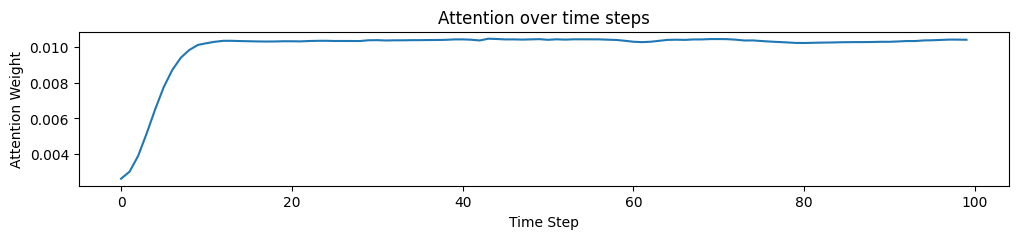

In [12]:
import matplotlib.pyplot as plt

def visualize_attention(sequence, attention_weights):
    plt.figure(figsize=(12, 2))
    plt.title("Attention over time steps")
    plt.plot(attention_weights.numpy().squeeze())
    plt.xlabel("Time Step")
    plt.ylabel("Attention Weight")
    plt.show()

# Get attention on a sample
sample = X_test[0:1]  # shape (1, time, features)
lstm_out, state_h, state_c = model.layers[1](sample)
_, att_weights = model.layers[2](lstm_out, state_h)

visualize_attention(sample, att_weights)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00        13

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21



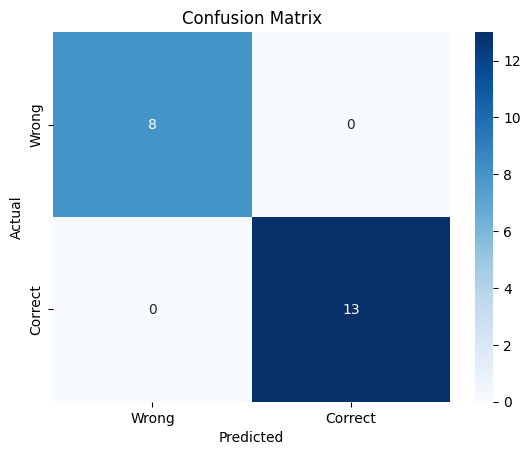

ROC-AUC Score: 1.0000


In [13]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Predict
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

# Print classification report
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Wrong', 'Correct'], yticklabels=['Wrong', 'Correct'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC-AUC Score
roc_score = roc_auc_score(y_test, y_pred_probs)
print(f"ROC-AUC Score: {roc_score:.4f}")


In [14]:
pip install optuna


Note: you may need to restart the kernel to use updated packages.


In [21]:
import optuna
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
import numpy as np

# Your custom AdditiveAttention
class AdditiveAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(AdditiveAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, values, query):
        query_with_time_axis = tf.expand_dims(query, 1)
        score = self.V(tf.nn.tanh(self.W1(values) + self.W2(query_with_time_axis)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

# Dummy placeholders — replace with your real data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

def objective(trial):
    lstm_units = trial.suggest_int("lstm_units", 32, 128)
    attention_units = trial.suggest_int("attention_units", 16, 64)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [4, 8, 16, 32])

    # Model definition
    sequence_input = Input(shape=(X.shape[1], X.shape[2]))
    lstm_out, state_h, state_c = LSTM(lstm_units, return_sequences=True, return_state=True)(sequence_input)
    context_vector, _ = AdditiveAttention(attention_units)(lstm_out, state_h)
    x = Dropout(dropout_rate)(context_vector)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=sequence_input, outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=20,
        batch_size=batch_size,
        verbose=0  # Suppress output for speed
    )

    val_accuracy = history.history['val_accuracy'][-1]
    return val_accuracy

# Run the search
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

# Print the best result
print("Best trial:")
print(f"  Value: {study.best_trial.value}")
print("  Params: ")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")


[I 2025-06-08 13:41:54,593] A new study created in memory with name: no-name-3a449aca-7e1d-4fa4-8d41-ef08cf89f8d9
[I 2025-06-08 13:42:05,595] Trial 0 finished with value: 0.9523809552192688 and parameters: {'lstm_units': 92, 'attention_units': 25, 'dropout_rate': 0.39787208861140244, 'learning_rate': 4.189712410536523e-05, 'batch_size': 16}. Best is trial 0 with value: 0.9523809552192688.
[I 2025-06-08 13:42:20,481] Trial 1 finished with value: 1.0 and parameters: {'lstm_units': 108, 'attention_units': 17, 'dropout_rate': 0.2682832001188279, 'learning_rate': 0.007814040821825243, 'batch_size': 8}. Best is trial 1 with value: 1.0.
[I 2025-06-08 13:42:31,169] Trial 2 finished with value: 0.9523809552192688 and parameters: {'lstm_units': 95, 'attention_units': 20, 'dropout_rate': 0.19847343726232786, 'learning_rate': 2.7428391293047083e-05, 'batch_size': 16}. Best is trial 1 with value: 1.0.
[I 2025-06-08 13:42:57,683] Trial 3 finished with value: 1.0 and parameters: {'lstm_units': 127, '

Best trial:
  Value: 1.0
  Params: 
    lstm_units: 108
    attention_units: 17
    dropout_rate: 0.2682832001188279
    learning_rate: 0.007814040821825243
    batch_size: 8


In [22]:
# Use best parameters from Optuna
best_params = study.best_trial.params

# Build final model
sequence_input = Input(shape=(X.shape[1], X.shape[2]))
lstm_out, state_h, state_c = LSTM(
    best_params['lstm_units'], return_sequences=True, return_state=True)(sequence_input)

context_vector, _ = AdditiveAttention(best_params['attention_units'])(lstm_out, state_h)
x = Dropout(best_params['dropout_rate'])(context_vector)
output = Dense(1, activation='sigmoid')(x)

final_model = Model(inputs=sequence_input, outputs=output)
final_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the model (no early stopping)
final_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=40,
    batch_size=best_params['batch_size'],
    verbose=1
)

Epoch 1/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.4926 - loss: 1.2281 - val_accuracy: 0.5714 - val_loss: 0.6449
Epoch 2/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.6789 - loss: 0.6048 - val_accuracy: 0.7143 - val_loss: 0.4109
Epoch 3/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.7616 - loss: 0.4006 - val_accuracy: 0.9048 - val_loss: 0.2218
Epoch 4/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.9242 - loss: 0.2643 - val_accuracy: 1.0000 - val_loss: 0.0998
Epoch 5/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.9551 - loss: 0.2043 - val_accuracy: 1.0000 - val_loss: 0.1002
Epoch 6/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9330 - loss: 0.2144 - val_accuracy: 1.0000 - val_loss: 0.0720
Epoch 7/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9322 - loss: 0.1939 - val_accuracy: 1.0000 - val_loss: 0.0673
Epoch 8/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9225 - loss: 0.1658 - val_accuracy: 1.0000 - v

In [23]:
# Save the trained model
final_model.save("best_pu_attention_model.h5")
print("✅ Model saved as 'best_attention_model.h5'")

✅ Model saved as 'best_attention_model.h5'
